# Multi-armed bandit
### Thompson sampling with success probability constraint and stochastic rewards

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import ray
import time

from source import simluate_rayleigh_fading_channel
from source import ThompsonSamplingBandit, OuterLoopLinkAdaptation

plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

ray_redis_address = "10.0.0.5:15672"
ray.init(address=ray_redis_address, ignore_reinit_error=True, log_to_driver=False)

2020-02-15 17:49:58,165	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.


{'node_ip_address': '10.0.0.5',
 'object_store_address': '/tmp/ray/session_2020-02-15_13-57-29_997315_3448/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-15_13-57-29_997315_3448/sockets/raylet',
 'redis_address': '10.0.0.5:15672',
 'session_dir': '/tmp/ray/session_2020-02-15_13-57-29_997315_3448',
 'webui_url': None}

In [2]:
@ray.remote
def f():
    time.sleep(0.01)
    return ray.services.get_node_ip_address()

# Get a list of the IP addresses of the nodes that have joined the cluster.
ray_node_ips = set(ray.get([f.remote() for _ in range(1000)]))
print('Number of active Ray nodes: %d'%(len(ray_node_ips)))

Number of active Ray nodes: 1


# Load Offline Model

In [3]:
awgn_datafile = 'AWGN_DATASET.npy'
awgn_data = np.load( awgn_datafile, allow_pickle=True )[ ( ) ]

snr_vs_per = awgn_data['snr_vs_per']
snr_range_dB = awgn_data['snr_range_dB']

nrof_snr, nrof_rates = snr_vs_per.shape

In [4]:
packet_sizes = [152, 200, 248, 320, 408, 504, 600, 712, 808, 936, 
                936, 1032, 1192, 1352, 1544, 1736, 1800, 
                1800, 1928, 2152, 2344, 2600, 2792, 2984, 3240, 3496, 3624, 3752, 4008]

modorders    = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                4, 4, 4, 4, 4, 4, 4, 
                6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

target_per = 0.1
cqi_delay = 0
nrof_ttis = 1000
avg_snr_dB = 15
nrof_experiments = 2000

In [5]:
#code_rates = [p / (72 * 12 * m ) * 1024 for p, m in zip( packet_sizes, modorders) ]
#print( [(i, m, c) for i, m, c in zip( range( len(modorders)) , modorders, code_rates)] )
#REF_MCS_INDICES = [0, 1, 3, 5, 8, 9, 11, 14, 16, 20, 22, 24, 27, 28, 28]

In [6]:
from source import estimate_sinr_from_cqi, determine_per_at_sinr

nrof_cqi = 16
per_per_cqi = np.ndarray( ( len( packet_sizes ), nrof_cqi ) )
for cqi in range( nrof_cqi - 1):
    snr_dB = estimate_sinr_from_cqi(cqi, awgn_data)
    per_per_cqi[ :, cqi ] = determine_per_at_sinr(snr_dB, awgn_data)

In [ ]:
@ray.remote
def run_experiment( seed, nrof_ttis, cqi_delay, avg_snr_dB  ):
    
    from source import simluate_rayleigh_fading_channel
    from source import ThompsonSamplingBandit, OuterLoopLinkAdaptation

    packet_error_probabilities, channel_quality_indices = simluate_rayleigh_fading_channel( nrof_ttis, 
                                                                                            avg_snr_dB, 
                                                                                            awgn_data, 
                                                                                            packet_sizes, 
                                                                                            norm_doppler = 0.1, 
                                                                                            seed = seed,
                                                                                            cqi_error_std = 2.0)

    # Pre-generate ACK events for all rates for all channel samples
    packet_acks = np.ndarray( ( nrof_ttis, nrof_rates ) )
    for tti in range( nrof_ttis ):
        for rate_index in range( nrof_rates ):
            packet_acks[tti, rate_index] = np.random.uniform( ) > packet_error_probabilities[tti, rate_index]

            
    # Outer Loop Link Adaptation
    olla_bandit = OuterLoopLinkAdaptation(nrof_rates, packet_sizes, awgn_data, target_per, olla_step_size=0.1)
    
    olla_rates  = []
    olla_acks  = []
    olla_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]    
        selected_rate_index = olla_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        olla_bandit.update( selected_rate_index, cqi, ack )

        olla_rates.append(selected_rate_index)
        olla_acks.append(ack)
        olla_tputs.append( packet_sizes[ selected_rate_index ] * ack )
        
        
    # Thompson Sampling
    ts_bandit = ThompsonSamplingBandit(nrof_rates, packet_sizes, target_per)
    
    ts_rates  = [] 
    ts_acks  = []
    ts_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]
        selected_rate_index = ts_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        ts_bandit.update( selected_rate_index, cqi, ack )

        ts_rates.append( selected_rate_index )
        ts_acks.append( ack )
        ts_tputs.append( packet_sizes[ selected_rate_index ] * ack )
        
    
    # Thompson Sampling with Informed Priors
    ts_infp_bandit = ThompsonSamplingBandit(nrof_rates, packet_sizes, target_per, per_per_cqi)
    
    ts_infp_rates  = []
    ts_infp_acks  = []
    ts_infp_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]    
        selected_rate_index = ts_infp_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        ts_infp_bandit.update( selected_rate_index, cqi, ack )

        ts_infp_rates.append(selected_rate_index)
        ts_infp_acks.append(ack)
        ts_infp_tputs.append( packet_sizes[ selected_rate_index ] * ack )
    
    return ( olla_rates, olla_acks, olla_tputs, 
             ts_rates, ts_acks, ts_tputs, 
             ts_infp_rates, ts_infp_acks, ts_infp_tputs, )

In [ ]:
olla_mcs = []
olla_ack = []
olla_tput = []

ts_mcs = []
ts_ack = []
ts_tput = []

ts_infp_mcs = []
ts_infp_ack = []
ts_infp_tput = []

results = ray.get( [ run_experiment.remote( i, nrof_ttis, cqi_delay, avg_snr_dB ) for i in range(nrof_experiments) ] )
#results = [ run_experiment( seed = i ) for i in range(2) ]

for res in results:
    olla_mcs.append( res[0] )
    olla_ack.append( res[1] )
    olla_tput.append( res[2] )
    
    ts_mcs.append( res[3] )
    ts_ack.append( res[4] )
    ts_tput.append( res[5] )
    
    ts_infp_mcs.append( res[6] )
    ts_infp_ack.append( res[7] )
    ts_infp_tput.append( res[8] )

In [ ]:
data= { 'olla': ([], olla_ack, olla_tput),
        'ts': ([], ts_ack, ts_tput),
        'ts_infp': ([], ts_infp_ack, ts_infp_tput)}

In [ ]:
np.save('RESULT_SNR_%d_TARGET_%0.1f_DELAY_%d_CQI_OFFSET_5dB.npy'%( avg_snr_dB, target_per, cqi_delay), data)

In [ ]:
plt.plot(np.mean(np.array(olla_tput)[:, ::10] / (72 * 15), axis=0))
plt.plot(np.mean(np.array(ts_tput)[:, ::10] / (72 * 15), axis=0))
plt.plot(np.mean(np.array(ts_infp_tput)[:, ::10] / (72 * 15), axis=0))

plt.legend(['OLLA', 'TS', 'TS-Infp'])

In [ ]:
plt.semilogy(1.0 - np.mean(np.array(olla_ack)[:, ::10], axis=0))
plt.semilogy(1.0 - np.mean(np.array(ts_ack)[:, ::10], axis=0))
plt.semilogy(1.0 - np.mean(np.array(ts_infp_ack)[:, ::10], axis=0))

plt.legend(['OLLA', 'TS', 'TS-Infp'])

In [ ]:
plt.plot( np.convolve(np.mean(np.array(olla_tput)[:, :] / (72 * 15), axis=0), np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.mean(np.array(ts_tput)[:, :] / (72 * 15), axis=0), np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.mean(np.array(ts_infp_tput)[:, :] / (72 * 15), axis=0), np.ones((1000,))/1000, mode='valid'))

plt.legend(['OLLA', 'TS', 'TS-Infp'])

In [ ]:
plt.plot( np.convolve(np.mean(np.array(olla_ack)[:, :], axis=0), np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.mean(np.array(ts_ack)[:, :], axis=0), np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.mean(np.array(ts_infp_ack)[:, :], axis=0), np.ones((1000,))/1000, mode='valid'))

plt.legend(['OLLA', 'TS', 'TS-Infp'])

In [ ]:
plt.plot( np.convolve(np.array(olla_tput)[0, :] / (72 * 15), np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.array(ts_tput)[0, :] / (72 * 15), np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.array(ts_infp_tput)[0, :] / (72 * 15), np.ones((1000,))/1000, mode='valid'))

plt.legend(['OLLA', 'TS', 'TS-Infp'])

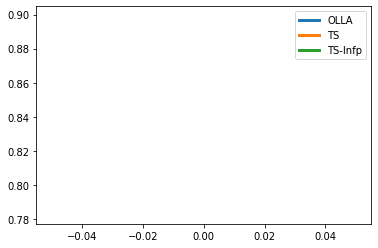

In [16]:
plt.plot( np.convolve(np.array(olla_ack)[0, :], np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.array(ts_ack)[0, :], np.ones((1000,))/1000, mode='valid'))
plt.plot( np.convolve(np.array(ts_infp_ack)[0, :], np.ones((1000,))/1000, mode='valid'))

plt.legend(['OLLA', 'TS', 'TS-Infp'])

In [4]:
#plt.figure()
#plt.grid(True)
#for i in range(nrof_rates):
#    plt.semilogy(snr_range_dB, snr_vs_per[:, i])
#plt.xlabel( 'SNR' )
#plt.ylabel( 'PER')
    
#plt.show()

In [7]:
#from source import determine_cqi_from_sinr

#cqi = []
#for s in snr_range_dB:
#    cqi.append( determine_cqi_from_sinr(s, packet_sizes, awgn_data) )
    
#plt.plot( snr_range_dB, cqi )
#plt.xlabel('Instantaneous SNR [dB]')
#plt.ylabel('CQI')

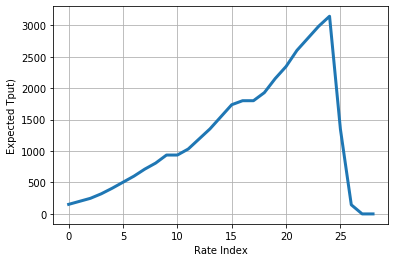

In [11]:
#from source import determine_per_at_sinr

#packet_error_probabilities = determine_per_at_sinr( 15, awgn_data)
#expected_tputs = [ (1-per) * psize for per, psize in zip( packet_error_probabilities, packet_sizes )]

#plt.figure()
#plt.grid(True)
#plt.plot(expected_tputs)

#plt.xlabel('Rate Index')
#plt.ylabel('Expected Tput)')
#plt.show()

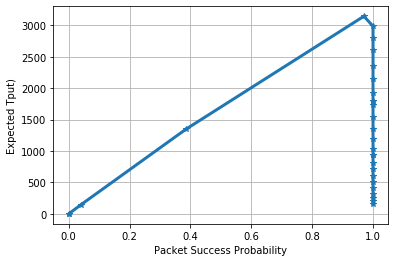

In [12]:
#plt.figure()
#plt.grid(True)
#plt.plot(1.0 - packet_error_probabilities, expected_tputs, '-*')

#plt.xlabel('Packet Success Probability')
#plt.ylabel('Expected Tput)')
#plt.show()